In [100]:
##https://github.com/martindlarsson/blocket_scraper
import argparse
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import sqlite3
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

%matplotlib inline

PATH = "data.csv";
train_car_data = pd.read_csv(PATH)

In [101]:
train_car_data.head(5)

,id,brand,gear,model,price,fuel,milage,hp,type,geo,model_year
0,0,Saab,Manuell,9-5,25000,Diesel,30 000 - 34 999,149,Kombi,Simrishamn,2006
1,1,Volvo,Automat,S80,85000,Diesel,18 000,163,Sedan,Helsingborg,2011
2,2,Renault,Manuell,CLIO,143900,Bensin,140,89,Halvkombi,"Göteborg, Hisingen",2018
3,3,Volvo,Automat,V70,32500,Bensin,20 000,199,Kombi,NaN,2001
4,4,Peugeot,Automat,207,98900,Bensin,10 588,119,Cab,NaN,2010


In [102]:
train_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107305 entries, 0 to 107304
Data columns (total 11 columns):
id            107305 non-null int64
brand         107305 non-null object
gear          107305 non-null object
model         107305 non-null object
price         107305 non-null int64
fuel          107305 non-null object
milage        107305 non-null object
hp            107305 non-null object
type          107305 non-null object
geo           45384 non-null object
model_year    107305 non-null int64
dtypes: int64(3), object(8)
memory usage: 9.0+ MB


In [103]:
#droping extra/unneeded columns
#train_car_data = train_car_data.drop('regnr', axis =1)
train_car_data = train_car_data.drop('id', axis =1)
#train_car_data = train_car_data.drop('add_date', axis =1)
#train_car_data = train_car_data.drop('make_year', axis =1)
train_car_data = train_car_data[train_car_data.brand != "Övriga"]
train_car_data = train_car_data.dropna(subset=['model', 'brand','price'])

In [104]:
train_car_data.head(5)

,brand,gear,model,price,fuel,milage,hp,type,geo,model_year
0,Saab,Manuell,9-5,25000,Diesel,30 000 - 34 999,149,Kombi,Simrishamn,2006
1,Volvo,Automat,S80,85000,Diesel,18 000,163,Sedan,Helsingborg,2011
2,Renault,Manuell,CLIO,143900,Bensin,140,89,Halvkombi,"Göteborg, Hisingen",2018
3,Volvo,Automat,V70,32500,Bensin,20 000,199,Kombi,NaN,2001
4,Peugeot,Automat,207,98900,Bensin,10 588,119,Cab,NaN,2010


In [105]:
train_car_data.shape

(107305, 10)

In [106]:
train_car_data["geo"] = train_car_data["geo"].replace(np.nan,"Sweden", regex=True)
train_car_data["geo"] = train_car_data["geo"].replace("-","Sweden", regex=True)
train_car_data["type"] = train_car_data["type"].replace(np.nan,"Sedan", regex=True)
train_car_data["type"] = train_car_data["type"].replace("-","Sedan", regex=True)
train_car_data["gear"] = train_car_data["gear"].replace(np.nan,"Manuell", regex=True)
train_car_data["gear"] = train_car_data["gear"].replace("-","Manuell", regex=True)
train_car_data["fuel"] = train_car_data["fuel"].replace(np.nan,"Bensin", regex=True)
train_car_data["fuel"] = train_car_data["fuel"].replace("-","Bensin", regex=True)

 
train_car_data['milage'] = train_car_data['milage'].replace(" ", "", regex=True)
train_car_data['milage'] = train_car_data['milage'].apply(lambda x: x[5:] if "Merän" in x else (x if x.find("-") == -1 else x[:x.find("-")]))
train_car_data['milage'] = train_car_data['milage'].astype(float)

train_car_data["hp"] = train_car_data["hp"].replace("0",np.nan, regex=True)
train_car_data["hp"] = train_car_data["hp"].replace("-",np.nan, regex=True)
train_car_data['hp'] = train_car_data['hp'].astype(float)
#BRAND SHOULD BE CHANGE WITH MODEL(model) FOR BETTER ACCURECY FOR NOW THIS COUSE 5% WORST ACCURECY IN OUR MODEL
train_car_data["hp"]= train_car_data.groupby(["brand"])["hp"].transform(lambda x:x.fillna(x.median()))

In [107]:
#drop the outlier
train_car_data = train_car_data[(train_car_data.hp > 40)]
train_car_data = train_car_data[(train_car_data.price > 4000)]
train_car_data = train_car_data[(train_car_data.price < 5000000)]
train_car_data =  train_car_data[(train_car_data.milage < 300000)]
train_car_data = train_car_data[(train_car_data.hp < 800)]

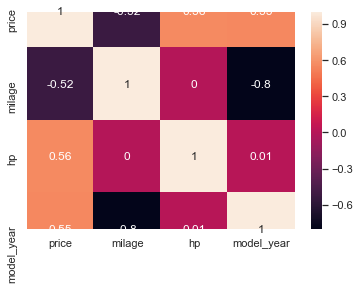

In [108]:
import seaborn as sns
sns.set()

sns.heatmap(train_car_data.corr().round(2), annot=True)

In [109]:
train_car_data.groupby(['brand','model','model_year']).agg({'price':['mean','count']}).sort_values(('price','count'), ascending=False)[:10]

price      
                                          mean count
brand         model  model_year                     
Volkswagen    GOL    2018        224073.205634   710
                     2016        155660.164360   578
              PASSAT 2018        314325.751880   532
              GOL    2017        184061.134576   483
Mercedes-Benz C220   2019        470588.111345   476
Volvo         V90    2019        409413.711584   423
Mercedes-Benz C220   2018        410492.426540   422
Volvo         V40    2018        231160.952381   420
              V60    2018        298142.564103   390
Volkswagen    GOL    2019        230266.490765   379

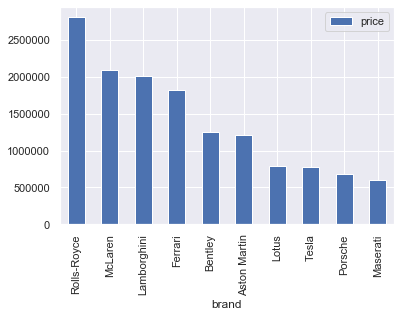

In [110]:
train_car_data.pivot_table(index=['brand'], values=['price'], aggfunc=np.mean).round(2).sort_values('price', ascending=False)[:10].plot.bar()

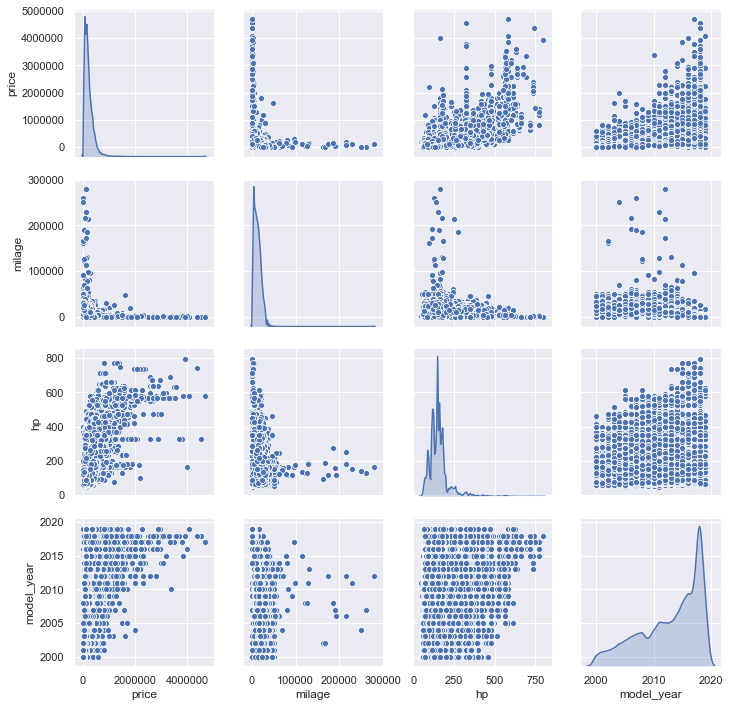

In [111]:
sns.pairplot(train_car_data[['price','milage','hp','model_year']], diag_kind='kde')

In [112]:
# correlation of each numeric feature with target 'price_eur' feature
feature_corr = train_car_data.corr()
print(feature_corr['price'].sort_values(ascending=False))

price         1.000000
hp            0.563394
model_year    0.553860
milage       -0.518123
Name: price, dtype: float64


In [113]:
X = train_car_data.drop(['price'], axis=1).copy()
X = pd.get_dummies(X, dummy_na = False, columns=['gear','fuel'] )
lb_make = LabelEncoder()
X["geo"] = lb_make.fit_transform(X["geo"])
X["type"] = lb_make.fit_transform(X["type"])
X["model_code"] = lb_make.fit_transform(X["model"])
X["brand_code"] = lb_make.fit_transform(X["brand"])
X = X.drop('brand', axis =1)
X = X.drop('model', axis =1)

y = train_car_data.price.values.copy() # prices in R$

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [114]:
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import ensemble

models = [DummyRegressor(),
          KNeighborsRegressor(),
          linear_model.Lasso(),
          linear_model.Ridge(),
          linear_model.ElasticNet(),
          ensemble.GradientBoostingRegressor(),
          ensemble.RandomForestRegressor(),
          ensemble.ExtraTreesRegressor()]

models_names = ['Dummy','K-nn','Lasso','Ridge','Elastic','Boost','Forest','Extra']

In [115]:
scores = []
mse = []
mae = []

for model in models:
    model = model.fit(X_train,y_train)
    scores.append(metrics.r2_score(y_test, model.predict(X_test)))
    mse.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mae.append(metrics.median_absolute_error(y_test, model.predict(X_test)))

C:\Users\sakog\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\sakog\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0, 0.5, 'Median absolute error')

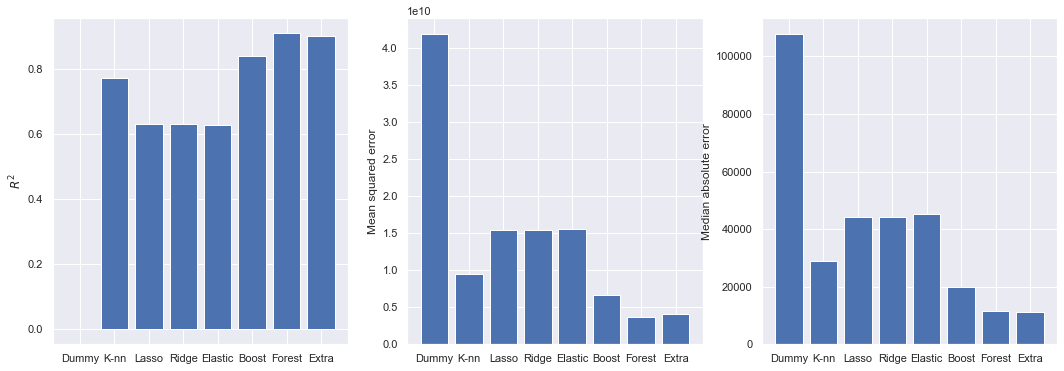

In [116]:
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=False, figsize=(18,6))
ax1.bar(models_names, scores)
ax1.set_ylabel('$R^2$')
ax2.bar(models_names, mse)
ax2.set_ylabel('Mean squared error')
ax3.bar(models_names, mae)
ax3.set_ylabel('Median absolute error')

In [117]:
model = models[6]

In [118]:
pred = pd.DataFrame.from_dict({'predicted':model.predict(X_test), 'true':y_test})
pred['difference'] = pred.predicted - pred.true
pred.sample(n=10).round(2)

,predicted,true,difference
6857,127850.00,114900,12950.00
14726,84847.50,49000,35847.50
7377,61920.00,69900,-7980.00
249,284900.00,299900,-15000.00
8042,200320.00,199900,420.00
15105,234620.00,235700,-1080.00
19330,408570.00,639900,-231330.00
17677,179627.50,169900,9727.50
19561,37770.00,19900,17870.00
1064,184116.19,182600,1516.19


In [119]:
pred.difference.describe().round(2)

count      21262.00
mean         540.91
std        61032.45
min     -3677100.10
25%        -9540.00
50%         1540.00
75%        13370.00
max      1551000.00
Name: difference, dtype: float64

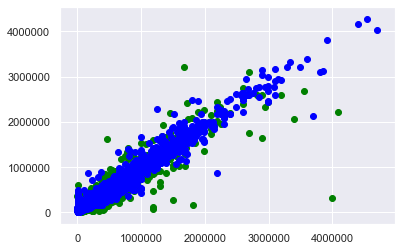

In [123]:
ypredtest = model.predict(X_test)
ypredtrain = model.predict(X_train)

plt.scatter(y_test, ypredtest, color='green')
plt.scatter(y_train, ypredtrain, color='blue')

plt.show()

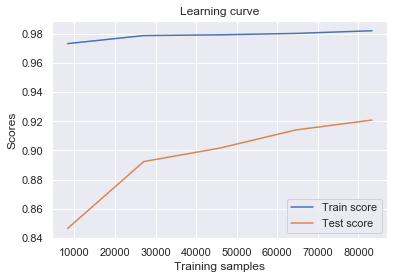

In [122]:
from sklearn.model_selection import learning_curve

learn_tr_size, learn_train_sc, learn_test_sc = learning_curve(model, X_train, y_train, cv=50)

# calculate mean over cross-validation folds
learn_train_m = np.apply_along_axis(np.mean, 1, learn_train_sc)
learn_test_m  = np.apply_along_axis(np.mean, 1, learn_test_sc)

plt.plot(learn_tr_size, learn_train_m)
plt.plot(learn_tr_size, learn_test_m)
plt.title('Learning curve')
plt.xlabel('Training samples')
plt.ylabel('Scores')
plt.legend(['Train score','Test score'])